## S5k example/demo notebook
Demo/example of the S5k module summing fast and slow ramps with individual amplitude control.

In [1]:
from spirack import SPI_rack, S5k_module
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import ipywidgets as ip

Open SPI rack connection and unlock (necessary after bootup of the controller module).

In [2]:
spi = SPI_rack("COM4", 1000000, 1)
spi.unlock()

Create new S5k module object at correct address and set clock source to internal clock and divide by 20. For all settings a 10 MHz external clock is assumed. The clock can be divided by all even numbers between 2-510.

In [3]:
s5k = S5k_module(spi, 3)
s5k.set_clock_source('internal')
s5k.set_clock_division(10)

Set the fast ramping DACs (1-4) to AWG (RAM readout) mode. This allows us to create a ramp of ~80 us. The slow ramp DACs (9-12) should be set to sawtooth mode. This allows for the creation of ~8 ms ramps.

In [4]:
for DAC in range(1,5):
    s5k.set_waveform_mode(DAC, 'AWG')
    s5k.set_digital_gain(DAC, 0.5)
    
for DAC in range(9,13):
    s5k.set_waveform_mode(DAC, 'sawtooth')
    s5k.set_digital_gain(DAC, 0.5)

The sawtooth ramp time length is given by: $$t_{saw} = \frac{2^{14}\cdot n}{f_{ext}}$$

Where $f_{ext}$ is the external clock frequency and $n$ the amount of clock ticks per sawtooth step. For a sawtooth ramp time of ~8ms with an external clock of 10 MHz this gives $n=5$: $$t_{saw} = \frac{2^{14}\cdot 5}{10^6} = 8.192 \text{ ms}$$

So we set the DACs (that are set to sawtooth) to a stepsize of n=5 and a ramp-up sawtooth.

In [5]:
for DAC in range(9,13):
    s5k.set_sawtooth_parameters(DAC, 'ramp_up', 5)

If we want the fast ramp to be 100 times shorter than the slow ramp it has to be 81.92 $\mu s$. At a sample rate of 10 MHz, this gives 819.2 -> 819 samples. This gives a fast sawtooth time of 81.9 $\mu s$. This has a downside that the two waveforms don't exactly fit. If we make it a division by a power of two: 128 times as small, it will. Dividing by 128 gives 64 $\mu s$ which would give 640 samples at 10 MHz.

<IPython.core.display.Javascript object>


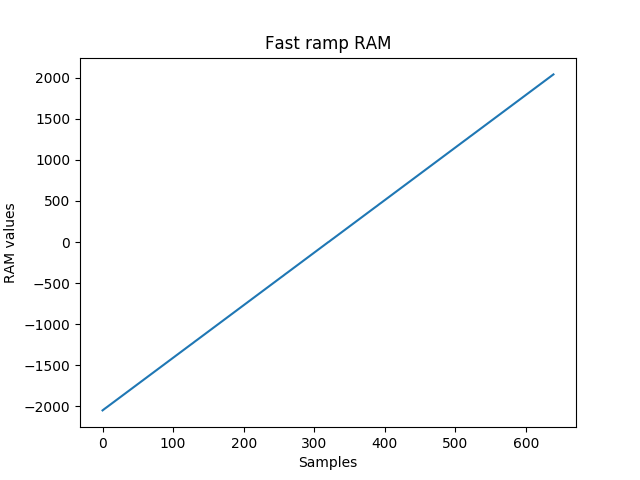

In [6]:
wv_len = 640

max_val = 2047
min_val = -2048

waveform_data = ((max_val-min_val)/wv_len) * np.arange(0, wv_len) + min_val
# Need to be integer values, smarter to cast after calculation for rounding errors
waveform_data = waveform_data.astype(int)

plt.figure()
plt.plot(waveform_data)
plt.title("Fast ramp RAM")
plt.xlabel("Samples")
plt.ylabel("RAM values")
plt.show()

The waveform only needs to be uploaded once to the chip containing the DACs that generate the fast ramp. This is a shared memory and we simply point all the DACs to use the same piece of memory.

In [7]:
s5k.upload_waveform(1, waveform_data, 0, set_pattern_length=True)

for DAC in range(1,5):
    s5k.set_RAM_address(DAC, 0, len(waveform_data)-1)

Set run_module to true to set all the modules to running and give a hardware trigger via the backplane. This hardware trigger is mirrored to the front to be able to trigger a digitizer. The digitizer/acquisition system should be set to trigger on the falling edge: the module outputs low if it is running and high if it is idle.

In [8]:
s5k.run_module(True)

For a demo: knobs for the gain of all the DACs.

In [20]:
def set_gain(DAC, value):
    s5k.set_digital_gain(DAC, value)

DACs = [1,2,3,4,9,10,11,12]
sliders = [ip.widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.01, description='DAC'+str(i)) for i in DACs] 
for i in range(0,len(DACs)):
    ip.interact(set_gain, DAC=ip.fixed(DACs[i]), value=sliders[i])

In [ ]:
spi.close()